<a href="https://colab.research.google.com/github/aliceshi2023/DS_002/blob/main/bike_share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Income prediction based on age, race, education, and/or gender (m/f)

This data was extracted from the [1994 Census bureau database](http://www.census.gov/en.html) by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics).

An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc.

This is a widely cited KNN dataset. I encountered it during my course, and I wish to share it here because it is a good starter example for data pre-processing and machine learning practices.

## Can you predict whether a given adult makes more than $50,000 a year based attributes such as age, race, gender (M/F), education attained, hours of work per week, etc. ?

### Fields
The dataset contains 16 columns

Target field: *Income*
> The income is divide into two classes: <=50K and >50K

14 attributes: *age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country*

> These are the demographics and other features to describe a person

We can explore the possibility in predicting income level based on the individual’s personal information.

Acknowledgements
This dataset named “adult” is found in the UCI machine learning repository
http://www.cs.toronto.edu/~delve/data/adult/desc.html

The detailed description on the dataset can be found in the original UCI documentation
http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

# Imports

Import your "by scratch" code first. Your repo should contain the following files:

```bash
byscratch
├── gradient_descent.py
├── k_nearest_neighbors.py
├── linear_algebra.py
├── probability.py
└── statistics.py
```

## Changes to the code from our textbook
These changes should make things easier

1. put imports at the top
1. used relative imports to avoid namespace problems
1. remove the `main()` loop

# Please update your repository to contain these files. Find them in this new repository:

https://github.com/douglasgoodwin/byscratch.git

In [ ]:
# Clone your code into a directory called `byscratch`
# 
! rm -Rf byscratch ;
!git clone https://github.com/angelessoriano1/byscratch.git byscratch

Cloning into 'byscratch'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 48 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [ ]:
# Import Your code
from byscratch.linear_algebra import Vector, Matrix
from byscratch.linear_algebra import make_matrix
from byscratch.linear_algebra import sum_of_squares
from byscratch.linear_algebra import dot
from byscratch.linear_algebra import subtract
from byscratch.linear_algebra import magnitude
from byscratch.linear_algebra import scalar_multiply
from byscratch.linear_algebra import vector_mean
from byscratch.linear_algebra import distance
from byscratch.linear_algebra import add

from byscratch.statistics import correlation
from byscratch.statistics import standard_deviation
from byscratch.statistics import median
from byscratch.statistics import mean
from byscratch.statistics import de_mean
from byscratch.statistics import standard_deviation

from byscratch.gradient_descent import gradient_step

from byscratch.probability import inverse_normal_cdf

from byscratch.working_with_data import rescale

In [ ]:
# python library imports
import random, datetime, re, csv, math, enum
from collections import defaultdict, Counter, OrderedDict
from typing import Tuple, List, NamedTuple, Optional, Callable
from typing import TypeVar, List, Iterator

# external code
from dateutil.parser import parse
import tqdm

# pyplot configs
import seaborn as sns
from matplotlib import pyplot as plt

# font
plt.rcParams.update({'font.size': 8})

# reset the default figsize value
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

# 144 is good for a high-resolution display. Try 100 if it's too big
plt.rcParams["figure.dpi"] = (80)

# Sidebar: Stratify this data with Pandas

> Stratification is the process of dividing members of the population into homogeneous subgroups before sampling. The strata should define a partition of the population. That is, it should be collectively exhaustive and mutually exclusive: every element in the population must be assigned to one and only one stratum. Then simple random sampling is applied within each stratum. The objective is to improve the precision of the sample by reducing sampling error. It can produce a weighted mean that has less variability than the arithmetic mean of a simple random sample of the population. [Wikipedia](https://en.wikipedia.org/wiki/Stratified_sampling)

Here we want to ensure that there are equal numbers of adults with incomes above and below the $50k line. Create a new CSV file. 

The original dataset has 11208 clean rows of >50K, and 34014 clean rows of <=50K.

# Get the column names & the shape of this dataset

In [ ]:
# show the first two rows: header and data
!head -1 'byscratch/data/bike_sharing_daily.csv' > cols.txt ;
# !cat cols.txt

with open("cols.txt") as f:
    for line in f:
        cols = line.strip().split(',')

print("| i | col |")
print("|-- |---- |")
for i,c in enumerate(cols):
  print(f"| {i} | {c} |")

| i | col |
|-- |---- |
| 0 | instant |
| 1 | dteday |
| 2 | season |
| 3 | yr |
| 4 | mnth |
| 5 | holiday |
| 6 | weekday |
| 7 | workingday |
| 8 | weathersit |
| 9 | temp |
| 10 | atemp |
| 11 | hum |
| 12 | windspeed |
| 13 | casual |
| 14 | registered |
| 15 | cnt |


| i | col |
|-- |---- |
| 0 | instant |
| 1 | dteday |
| 2 | season |
| 3 | yr |
| 4 | mnth |
| 5 | holiday |
| 6 | weekday |
| 7 | workingday |
| 8 | weathersit |
| 9 | temp |
| 10 | atemp |
| 11 | hum |
| 12 | windspeed |
| 13 | casual |
| 14 | registered |
| 15 | cnt |

In [ ]:
# Get the shape of this dataset
filename = "byscratch/data/bike_sharing_daily.csv"
with open(filename) as f:
    numlines = sum(1 for line in f)-1

numlines

731

In [ ]:
# Load up a large data structure
data_dict = csv.DictReader(open(filename))

# Let's do some frequency counting
from collections import Counter

# race, gender, occupation, hours worked per week, and education
cnt = 0
days = 0
weekdays = []
seasons = []
temps = []
hums = []
winds = []
counts = []
seasons_text = ['spring','summer','fall','winter']

for row in data_dict:
  days = days+1

  cnt = int(row["cnt"])
  tcnt = cnt
  counts.append(cnt)

  # counters
  weekday = int(row["weekday"])
  weekdays.append(weekday)

  season = int(row["season"]) - 1
  seasons.append(seasons_text[season])

  # NOTE: multiply temp * 41 to get celsius
  temp = 41.0 * float(row["temp"])
  temps.append(temp)

  # multiple humidity * 100
  hum = 100.0 * float(row["hum"])
  hums.append(hum)

  # multiply windspeed * 100
  windspeed = 100.0 * float(row["windspeed"])
  winds.append(windspeed)

# SANITY CHECKS 
assert len(winds) == len(temps) == len(seasons) == len(weekdays) == len(hums)

# Use your code to get the mean & median hours per week
print(f"The mean windspeed is {mean(winds)}, median is {median(winds)}")

print(f"The mean humidity is {mean(hums)}, median is {median(hums)}")

print(f"The mean daily temperture is {mean(temps)}, median is {median(temps)}")

The mean windspeed is 19.04862116279071, median is 18.0975
The mean humidity is 62.78940629274965, median is 62.6667
The mean daily temperture is 20.31077632886456, median is 20.431653


In [ ]:
# Create dictionaries of frequency counts for ordinals. 
# Order the keys

def orderedCounter(alist):
    c = Counter(alist)
    ld = dict((str(k).lower(), v) for k, v in c.items())
    old = OrderedDict(sorted(ld.items()))
    return old

def orderedCounterInt(alist):
    c = Counter(alist)
    ld = dict((int(k), v) for k, v in c.items())
    s = sorted(ld.items())
    # print(s)
    old = OrderedDict(sorted(s))
    return old

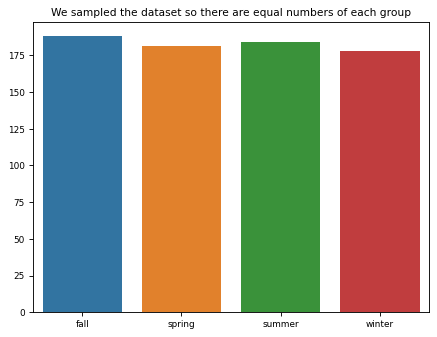

In [ ]:
# distribution of seasons? 
inc = orderedCounter(seasons)

sns.barplot(
    x=list(inc.keys()),
    y=list(inc.values()),
    orient='v')

plt.title("Distribution of Seasons")
plt.show()

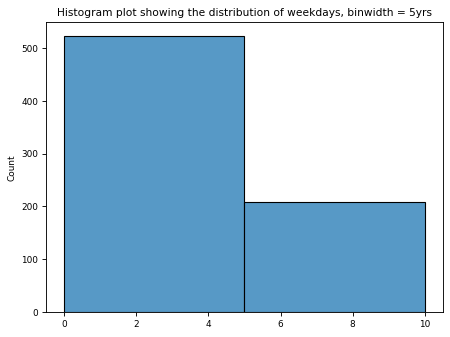

In [ ]:
# Weekdays histplot

sns.histplot(weekdays,binwidth=5)

plt.title("Histogram plot showing the distribution of weekdays, binwidth = 5yrs")
plt.show()

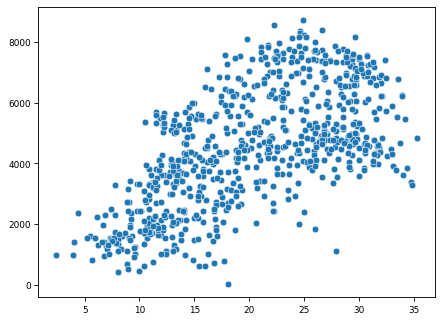

In [ ]:
sns.scatterplot(x=temps, y=counts) 



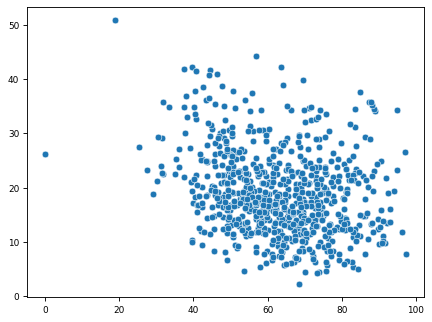

In [ ]:
sns.scatterplot(x=hums, y=winds) 